In [1]:
#https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/


# univariate multi-step vector-output stacked lstm example
# Importing the libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional,Dropout
from keras.layers import Dense
from keras.regularizers import L1L2
from numpy import hstack
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

def plot_eval(real_stock_price, predicted_stock_price):
    print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
    print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
    mean_absolute_er = mean_absolute_error(real_stock_price, predicted_stock_price)
    print("mean_absolute_error: ", mean_absolute_er)
    
    #real_stock_price, predicted_stock_price
    SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
    SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
    print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)
    out_arr = np.subtract(predicted_stock_price, real_stock_price)
    fig = plt.figure(figsize=(12,8))
    # Visualising the results
    plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def add_datepart(df, fldnames, drop=False, time=False, errors="raise"):	
    if isinstance(fldnames,str):
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64
        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        #targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[n] = getattr(fld.dt, n.lower())
        df['Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)
    df.drop(['Elapsed','Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'], axis=1, inplace=True)
        

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


def calc_feat(sequence, n_steps_in, n_steps_out):
    X= []
    k = 0 # row itreator
    size = len(sequence)
    for i in range(n_steps_in, size):
        vwap = 0
        vol = 0
        vchg = 0
        for j in range(n_steps_in):
            if (k<i):
#                print("i:", i," j:",j)
#                print("High, Low, Close", sequence[k, 0:3])
#                print("Vol", sequence[k, 4])
#                print("Change", sequence[k, 3])
                vwap += (((np.sum(sequence[k, 0:3]))/3) * sequence[k, 4])
                vchg += (((sequence[k, 3])) * sequence[k, 4])
                vol += sequence[k, 4]
                k = k+1
 #               print("vwap:", vwap, " vchg", vchg)
        #if vwap !=0  and vol != 0:
        
        X = np.append(X, vwap/vol) #vwap
        X = np.append(X, vchg/vol) #Change
        #X = np.append(X, sequence[i, 4]) #volume
        #X = np.append(X, sequence[i, 5]) #openInt
        #X = np.append(X, sequence[i, 6]) #DTWEXB
        #X = np.append(X, sequence[i, 7]) #Year
        #X = np.append(X, sequence[i, 8]) #Mnt
        #X = np.append(X, sequence[i, 9]) #Week
        #X = np.append(X, sequence[i, 10]) #DayofMonth
        #X = np.append(X, sequence[i, 11]) #Dayofweek
        #X = np.append(X, sequence[i, 12]) #Dayofyear
    
    num_of_features = 2 #num_of_features
    sz = size-(n_steps_in)
    X = np.array(X.reshape(sz, num_of_features)) 
    #X = X[:-(n_steps_out), :]
    return X


# load dataset
# Importing the training set
dataset_train = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/zsh20.csv') #, nrows=10
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_dxy = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/DTWEXB.csv')
dataset_train = pd.merge(dataset_train, dataset_dxy,  left_on='Time', right_on='Time', how='left')

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
# choose a number of time steps
n_steps_in, n_steps_out = 2, 15

add_datepart(dataset_train, 'Time')

dataset_train.set_index('Time', inplace=True)
print(dataset_train.shape)

# define input sequence
training_feat = dataset_train.iloc[:, 1:16].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_feat_scaled = sc.fit_transform(training_feat)

#X_feat = calc_feat(training_feat, n_steps_in, n_steps_out)
X_feat = calc_feat(training_feat_scaled, n_steps_in, n_steps_out)

# define input sequence
training_set = dataset_train.iloc[:, 3:4].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
raw_seq = sc.fit_transform(training_set)

# split into samples
X_whole, y_whole = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
#for i in range(len(X_whole)):
#	print(X_whole[i], y_whole[i])

X_whole = X_whole.reshape(X_whole.shape[0], X_whole.shape[1])
y_whole = y_whole.reshape(y_whole.shape[0], y_whole.shape[1])

#step2 model - drop 1st row
n_steps_out = 1
y_whole = y_whole[:,14:15]

trp_rows = X_feat.shape[0] - X_whole.shape[0]
if trp_rows>0:
    X_feat = X_feat[:-(trp_rows), :]
#Concate features
X_whole = hstack((X_whole, X_feat))
print(X_whole.shape)

Using TensorFlow backend.


(490, 14)
(474, 4)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


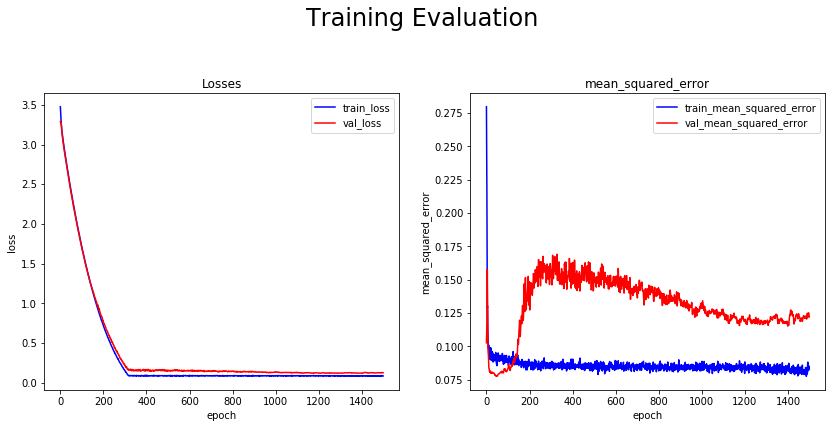

Day Prediction (Step):  1
sqrt mean_squared_error:  31.672549908732876
mean_squared_error:  1003.1504177211749
mean_absolute_error:  28.558305528428818
R Squared: [-0.54289461] 
Adjusted R Squared: [-0.66884519]


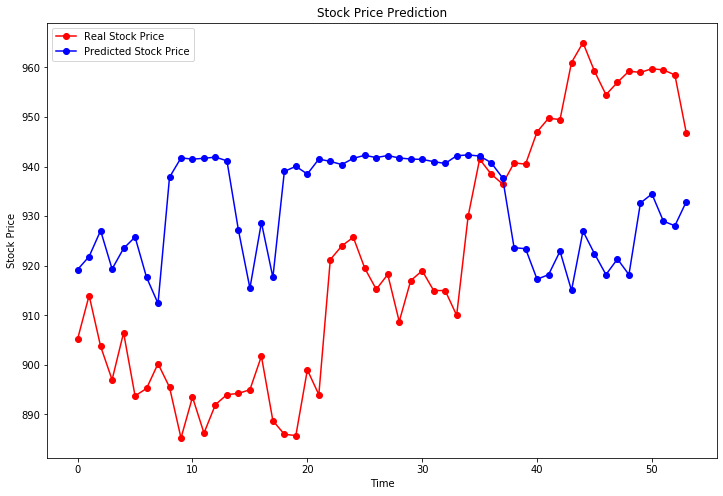

In [2]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(10,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=["mean_squared_error"]) #adam
# fit model , batch_size=32
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1500, verbose=0, batch_size=96)
# demonstrate prediction
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

# demonstrate prediction
yhat = model.predict(X_test, verbose=0)

for col in range(yhat.shape[1]):
    print("Day Prediction (Step): ", col+1)
    yhat[:,col:col+1] = sc.inverse_transform(yhat[:,col:col+1])
    y_test[:,col:col+1] = sc.inverse_transform(y_test[:,col:col+1])
    plot_eval(y_test[:,col:col+1],yhat[:,col:col+1])

[04:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.839870617921476 -0.7147376218005168
0.41349589803596914
sqrt mean_squared_error:  33.389793622609105
mean_squared_error:  1114.8783181604276
mean_absolute_error:  29.559395118995948
R Squared: [-0.71473761] 
Adjusted R Squared: [-0.85471619]


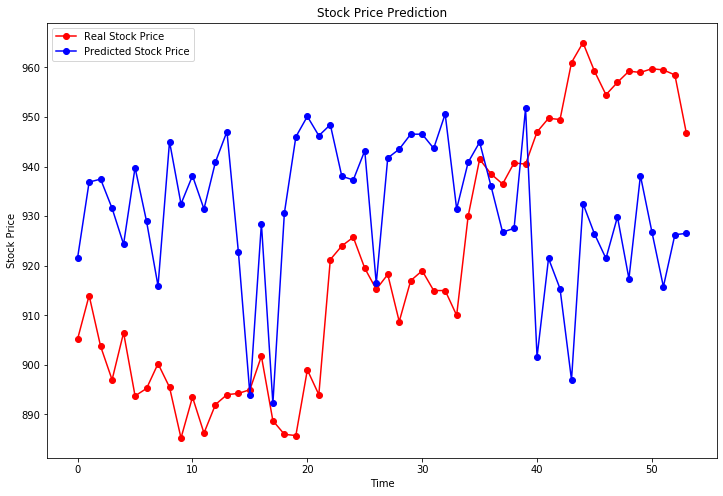

In [3]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

from sklearn.metrics import mean_squared_error as MSE
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.01, n_estimators=1500, n_jobs=1)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(np.sqrt(MSE(y_test, reg.predict(X_test))))
predicted_stock_price = reg.predict(X_test)

#create empty table with 6 fields to inverse
real_stock_price = sc.inverse_transform(y_test)

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
# create empty table with 6 fields to inverse
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [4]:
reg.feature_importances_

array([0.10068078, 0.24500312, 0.58590263, 0.06841341], dtype=float32)

In [5]:
X_whole.shape

(474, 4)

In [6]:
#Train -valid and Test split in time order
X_train = X_whole[0:420,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:420].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()
from sklearn.feature_selection import RFE
#no of features
nof_list=np.arange(1, X_train.shape[1])            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = XGBRegressor(learning_rate=0.01, n_estimators=1000, n_jobs=1)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        print(n, ": ", nof)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[04:58:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[04:58:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[04:58:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Optimum number of features: 0
Score with 0 features: 0.000000


In [7]:
#30 days lag, vwap, #openInt
#DTWEXB
#Year
#Mnt
#Week
#DayofMonth
#Dayofweek
#Dayofyear

cols = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'VWAP', 'Vol' , 'DTWEXB', "Week"]
model = XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_whole,y_whole)  
#Fitting the data to model
model.fit(X_rfe,y_whole)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print("Selected Features: ", selected_features_rfe)

[04:58:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoostError: [04:58:36] C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:723: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?